In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Preprocessing

### Data Gathering

In [50]:
indexes = []
all_indexes = {}

In [51]:
index_excel_file = '../Data/Index_Data.xlsx'
all_indexes = pd.read_excel(index_excel_file, sheet_name=None)

for sheet_name, df in all_indexes.items():
    indexes.append(sheet_name)
    all_indexes[sheet_name] = df

In [52]:
BSESN = all_indexes['BSESN']
BSESN.tail()

,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,Percent_Change_In_Price,Momentum_Indicator,High_Low_Change,High_Open_Change,Low_Open_Change,Day,Month,Year
6803,2025-02-11 00:00:00+05:30,77384.976562,77387.281250,76030.593750,76293.601562,9800,0,0,-0.013170,-0.014103,0.017844,0.000030,-0.017502,11,2,2025
6804,2025-02-12 00:00:00+05:30,76188.242188,76459.718750,75388.390625,76171.078125,10400,0,0,-0.001606,-0.000225,0.014211,0.003563,-0.010498,12,2,2025
6805,2025-02-13 00:00:00+05:30,76201.101562,76764.531250,76013.429688,76138.968750,6900,0,0,-0.000422,-0.000815,0.009881,0.007394,-0.002463,13,2,2025
6806,2025-02-14 00:00:00+05:30,76388.992188,76483.062500,75439.640625,75939.210938,9300,0,0,-0.002624,-0.005888,0.013831,0.001231,-0.012428,14,2,2025
6807,2025-02-17 00:00:00+05:30,75641.406250,76041.960938,75294.757812,75996.859375,0,0,0,0.000759,0.004699,0.009924,0.005295,-0.004583,17,2,2025


In [53]:
len(BSESN)

6808

### Feature Engineering

In [54]:
BSESN['Date'] = pd.to_datetime(BSESN['Date'])
BSESN = BSESN.sort_values('Date').reset_index(drop=True)

In [55]:
BSESN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6808 entries, 0 to 6807
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype                    
---  ------                   --------------  -----                    
 0   Date                     6808 non-null   datetime64[ns, UTC+05:30]
 1   Open                     6808 non-null   float64                  
 2   High                     6808 non-null   float64                  
 3   Low                      6808 non-null   float64                  
 4   Close                    6808 non-null   float64                  
 5   Volume                   6808 non-null   int64                    
 6   Dividends                6808 non-null   int64                    
 7   Stock_Splits             6808 non-null   int64                    
 8   Percent_Change_In_Price  6807 non-null   float64                  
 9   Momentum_Indicator       6808 non-null   float64                  
 10  High_Low_Change         

In [56]:
# features = ['Open', 'Close', 'Momentum_Indicator', 'High_Low_Change', 'High_Open_Change', 'Low_Open_Change', 'Day', 'Month', 'Year']
features = ['Momentum_Indicator', 'High_Low_Change', 'High_Open_Change', 'Low_Open_Change', 'Day', 'Month', 'Year']
target = 'Close'

In [57]:
X_data = BSESN[features].values
y_data = BSESN['Close'].values.reshape(-1, 1)

In [58]:
BSESN['Close']

0        4300.859863
1        4333.899902
2        4323.459961
3        4323.819824
4        4291.450195
            ...     
6803    76293.601562
6804    76171.078125
6805    76138.968750
6806    75939.210938
6807    75996.859375
Name: Close, Length: 6808, dtype: float64

In [59]:
BSESN['Close'].values

array([ 4300.85986328,  4333.89990234,  4323.45996094, ...,
       76138.96875   , 75939.2109375 , 75996.859375  ])

In [60]:
y_data

array([[ 4300.85986328],
       [ 4333.89990234],
       [ 4323.45996094],
       ...,
       [76138.96875   ],
       [75939.2109375 ],
       [75996.859375  ]])

### Data Normalization

In [61]:
scaler_features = StandardScaler()
scaler_target = StandardScaler()
scaled_X_data = scaler_features.fit_transform(X_data)
scaled_y_data = scaler_target.fit_transform(y_data)

### Create Sequences

In [62]:
# Create sequences for LSTM
def create_sequences(features, target, seq_length=90):
    X, y = [], []
    for i in range(seq_length, len(features)):
        X.append(features[i-seq_length:i, :])  # Use all features
        y.append(target[i, 0])  # Predict `Close` price
    return np.array(X), np.array(y)

In [63]:
X, y = create_sequences(scaled_X_data, scaled_y_data)

In [64]:
len(y)

6718

In [65]:
y[-2:]

array([2.58472466, 2.58756534])

In [66]:
X[-1:]

array([[[-0.39759004, -0.3488716 , -0.33346474,  0.13061905,
         -0.77398638,  1.00066108,  1.65317292],
        [-0.13914575, -0.89153864, -0.63214245,  0.52645334,
         -0.65981366,  1.00066108,  1.65317292],
        [-0.0187386 , -0.99233207, -0.59588026,  0.67454181,
         -0.54564095,  1.00066108,  1.65317292],
        [ 0.46302046, -0.82085697, -0.12905404,  0.84840573,
         -0.20312279,  1.00066108,  1.65317292],
        [-0.1971308 , -0.68051547, -0.58941397,  0.31291547,
         -0.08895007,  1.00066108,  1.65317292],
        [-0.06548041, -0.77424964, -0.45344666,  0.53234347,
          0.02522265,  1.00066108,  1.65317292],
        [-0.65593092, -0.45013847, -0.85832408, -0.17204422,
          0.13939536,  1.00066108,  1.65317292],
        [ 0.54528694, -0.33092916,  0.10770978,  0.46296819,
          0.25356808,  1.00066108,  1.65317292],
        [-0.52654148, -0.3607234 , -0.89429027, -0.30478511,
          0.59608624,  1.00066108,  1.65317292],
        [-

### Data splitting

In [67]:
training_size = int(len(X) * 0.7)
validation_size = int(len(X) * 0.9)

X_train, X_validate, X_test = X[:training_size], X[training_size:validation_size], X[validation_size:]
y_train, y_validate, y_test = y[:training_size], y[training_size:validation_size], y[validation_size:]

print(len(X))
print(f"{len(X_train)}")
print(f"{len(X_validate)}")
print(f"{len(X_test)}")
print(f"{len(y_test)}")

6718
4702
1344
672
672


In [68]:
print(X.shape)
print(f"{X_train.shape}")
print(f"{X_validate.shape}")
print(f"{X_test.shape}")
print(f"{y_test.shape}")

(6718, 90, 7)
(4702, 90, 7)
(1344, 90, 7)
(672, 90, 7)
(672,)


# 2. Model creation

### Plot epoch vs loss & epoch vs mae

In [69]:
def plot_loss_mae(history):
    # Extract values from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']

    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mae, 'bo-', label='Training MAE')
    plt.plot(epochs, val_mae, 'r^-', label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.title('Training vs Validation MAE')
    plt.legend()

    plt.show()

### LSTM model

Epoch 1/13


2025-02-25 15:30:36.508335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-25 15:30:36.639207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  3/147 [..............................] - ETA: 5s - loss: 0.4811 - mean_absolute_error: 0.5954  

2025-02-25 15:30:36.896381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


147/147 [==============================] - ETA: 0s - loss: 0.1904 - mean_absolute_error: 0.3765

2025-02-25 15:30:39.739203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-02-25 15:30:39.780923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


147/147 [==============================] - 4s 21ms/step - loss: 0.1904 - mean_absolute_error: 0.3765 - val_loss: 1.9070 - val_mean_absolute_error: 1.3048
Epoch 2/13
147/147 [==============================] - 3s 18ms/step - loss: 0.1686 - mean_absolute_error: 0.3625 - val_loss: 1.9336 - val_mean_absolute_error: 1.3147
Epoch 3/13
147/147 [==============================] - 3s 18ms/step - loss: 0.1665 - mean_absolute_error: 0.3619 - val_loss: 1.8904 - val_mean_absolute_error: 1.2993
Epoch 4/13
147/147 [==============================] - 3s 18ms/step - loss: 0.1653 - mean_absolute_error: 0.3609 - val_loss: 2.0729 - val_mean_absolute_error: 1.3656
Epoch 5/13
147/147 [==============================] - 3s 18ms/step - loss: 0.1648 - mean_absolute_error: 0.3606 - val_loss: 1.8781 - val_mean_absolute_error: 1.2917
Epoch 6/13
147/147 [==============================] - 3s 18ms/step - loss: 0.1644 - mean_absolute_error: 0.3608 - val_loss: 2.0391 - val_mean_absolute_error: 1.3518
Epoch 7/13
147/147 [=

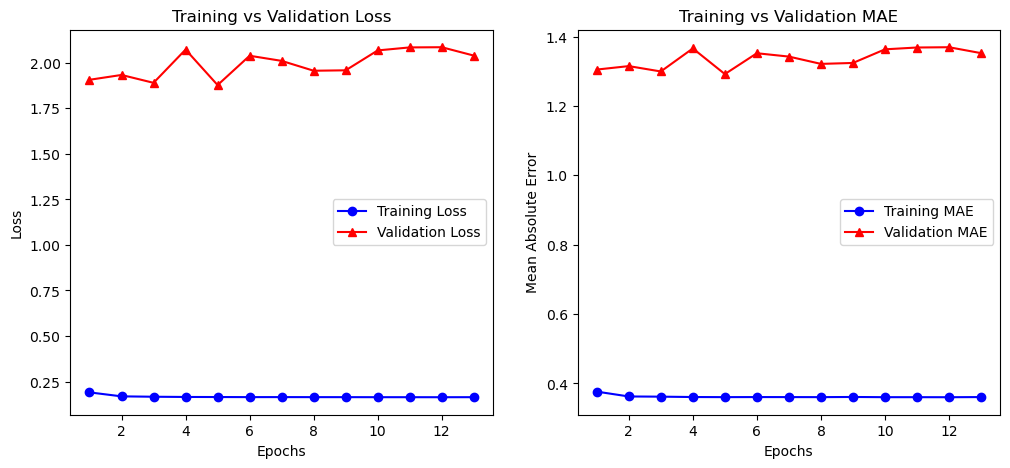

In [71]:
# # LSTM Model

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = LSTM(64, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
# x = LSTM(32, return_sequences=False)(x)
# x = Dropout(0.1)(x)
x = Dense(16, activation='tanh')(x)
# x = Dropout(0.2)(x)

output = Dense(1)(x)


model = Model(inputs, output)

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_absolute_error'])

history = model.fit(X_train, y_train, epochs=13, batch_size=32, validation_data=(X_validate, y_validate))

plot_loss_mae(history)